In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential

from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from keras.layers import Dropout

In [ ]:
#Custom Activation Function -- swish for Bidirectional Layer
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras.layers import Activation

def custom_activation(x, beta = 1):
        return (K.sigmoid(beta * x) * x)

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

Dataset used: [https://www.kaggle.com/stanley11291985/hk-macroeconomics-data](https://www.kaggle.com/stanley11291985/hk-macroeconomics-data)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Housing market data.xlsx to Housing market data (1).xlsx


In [ ]:
df=pd.read_excel('Housing market data.xlsx', parse_dates=['Date'])
df

,Date,Private Domestic (Price Index),First hand sales quantity,First hand sales amount,Total completions,Total stock,Total take up,Total vacancy,Unemployment rate (seasonally adjusted) (%),CPI,HIBOR (1-month),M3 (HK$ million),HSI - close,HSI - volume
0,2003-01-02,64.559769,1854.689208,5.846897e+09,33983.762413,1.092844e+06,19914.083323,74177.818318,7.301525,73.721486,1.444200,3.562189e+06,9365.519531,1.269074e+08
1,2003-01-03,64.506848,1892.762372,5.927523e+09,33932.818955,1.092244e+06,19900.006814,74155.621001,7.299043,73.717079,1.417410,3.562586e+06,9583.849609,2.914544e+08
2,2003-01-06,64.453848,1931.338866,5.998876e+09,33882.041253,1.091646e+06,19886.125236,74133.429251,7.296561,73.712684,1.404020,3.563044e+06,9665.959961,2.349128e+08
3,2003-01-07,64.400768,1970.418692,6.060958e+09,33831.429307,1.091050e+06,19872.438591,74111.243068,7.294081,73.708301,1.390630,3.563562e+06,9652.400391,2.670218e+08
4,2003-01-08,64.347610,2010.001848,6.113768e+09,33780.983117,1.090457e+06,19858.946877,74089.062450,7.291601,73.703930,1.397320,3.564141e+06,9688.209961,2.024392e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4228,2019-11-20,367.535153,3703.971873,2.414254e+10,24102.097251,1.214440e+06,-3709.657487,68524.599646,3.252151,110.013591,2.057968,1.429137e+07,26889.609375,1.333244e+09
4229,2019-11-21,367.108272,3812.401157,2.474971e+10,24116.858626,1.214539e+06,-3801.292428,68621.956325,3.252718,110.019627,2.060889,1.428063e+07,26466.880859,1.712162e+09
4230,2019-11-22,366.678619,3923.098735,2.537114e+10,24131.625774,1.214638e+06,-3893.129764,68719.495386,3.253286,110.025657,2.063812,1.426970e+07,26595.080078,1.100432e+09
4231,2019-11-25,366.246194,4036.064606,2.600682e+10,24146.398696,1.214737e+06,-3985.169494,68817.216827,3.253855,110.031681,2.066737,1.425859e+07,26993.039063,1.497176e+09


In [ ]:
df=df[['Date', 'Private Domestic (Price Index)']]
df.index=df['Date']

As the time series is irregularly sampled, we resample (to get daily frequency) and interpolate the missing Private Domestic values

In [ ]:
#Moving date to index for ease of interpolation
del df['Date']

In [ ]:
df=df.resample('D').mean()

In [ ]:
df['Private Domestic (Price Index)']=df['Private Domestic (Price Index)'].interpolate().values.ravel().tolist()

In [ ]:
df

,Private Domestic (Price Index)
Date,
2003-01-02,64.559769
2003-01-03,64.506848
2003-01-04,64.489181
2003-01-05,64.471514
2003-01-06,64.453848
...,...
2019-11-22,366.678619
2019-11-23,366.534478
2019-11-24,366.390336


In [ ]:
#Restoring Date as a column
df['Date']=df.index

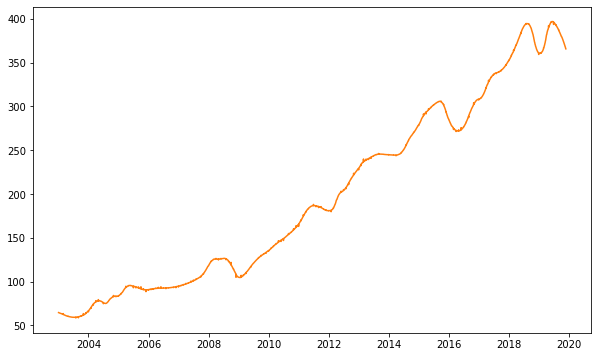

In [ ]:
#Plotting graph to view how Private Domestic varies with Date
plt.figure(figsize = (10, 6))

plt.plot(df['Date'],df['Private Domestic (Price Index)'], color='tab:orange')

Splitting into test and train data sets + Scaling



In [ ]:
train_size = int(len(df)*0.8)
date=df.pop('Date')
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

In [ ]:
scaler = MinMaxScaler().fit(train_data)
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [ ]:
def create_dataset (X, past):
    Xs, ys = [], []

    for i in range(len(X)-past):
        v = X[i:i+past]
        Xs.append(v)
        ys.append(X[i+past])

    return np.array(Xs), np.array(ys)
past = 31
X_train, y_train = create_dataset(train_scaled,past)
X_test, y_test = create_dataset(test_scaled,past)


Model creation

In [ ]:
def create_bilstm(units):
    model = Sequential()
    model.add(Activation(custom_activation,name = "Swish"))
    model.add(Bidirectional(
              LSTM(units = units, return_sequences=True),
              input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer="adam",loss="mse",metrics=['accuracy'])
    return model

model_bilstm = create_bilstm(64)


In [ ]:
def fit_model(model):
    path_checkpoint = "model_checkpoint.h5"
    early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                               patience = 10)

    modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
    )
    history = model.fit(X_train, y_train, epochs = 30,
                        validation_split = 0.40,
                        batch_size = 32, shuffle = False,
                        callbacks = [modelckpt_callback])
    return history

history_bilstm = fit_model(model_bilstm)

Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 6.9135e-04 - accuracy: 3.3967e-04
Epoch 1: val_loss improved from inf to 0.02681, saving model to model_checkpoint.h5
92/92 [==============================] - 17s 104ms/step - loss: 6.9135e-04 - accuracy: 3.3967e-04 - val_loss: 0.0268 - val_accuracy: 5.0942e-04
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 3.3967e-04
Epoch 2: val_loss did not improve from 0.02681
92/92 [==============================] - 7s 76ms/step - loss: 0.0028 - accuracy: 3.3967e-04 - val_loss: 0.0275 - val_accuracy: 5.0942e-04
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 0.0065 - accuracy: 3.3967e-04
Epoch 3: val_loss did not improve from 0.02681
92/92 [==============================] - 6s 70ms/step - loss: 0.0065 - accuracy: 3.3967e-04 - val_loss: 0.0541 - val_accuracy: 5.0942e-04
Epoch 4/30
92/92 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 3.3967e-04
Epoch 

In [ ]:
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

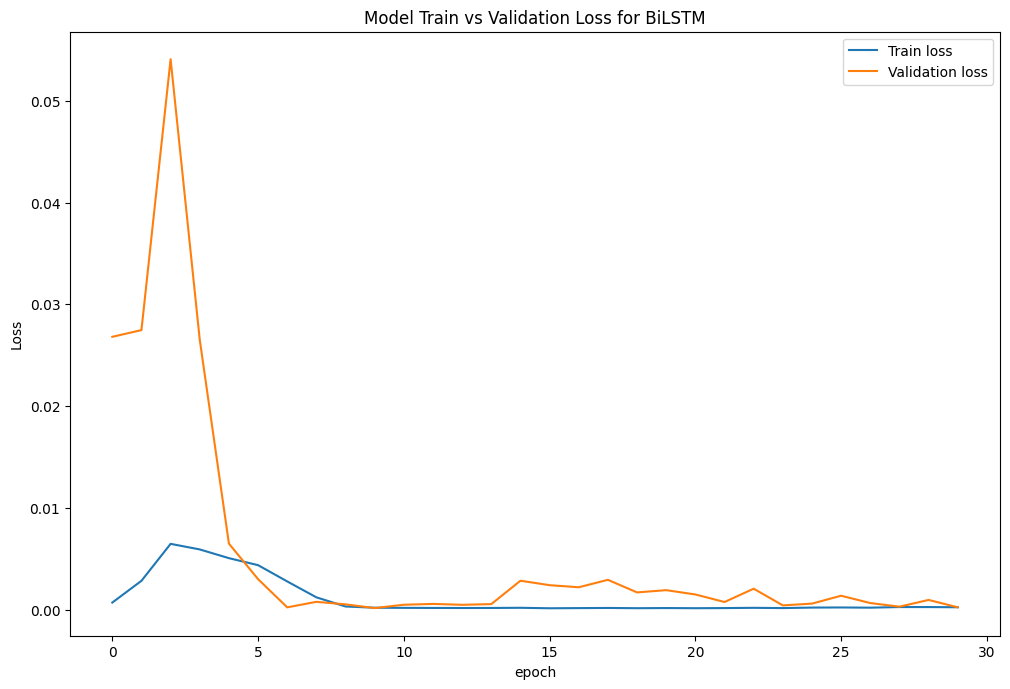

In [ ]:
plt.figure(figsize = (12, 8), dpi=100)
plt.plot(history_bilstm.history["loss"])
plt.plot(history_bilstm.history["val_loss"])
plt.title("Model Train vs Validation Loss for BiLSTM")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(["Train loss", "Validation loss"], loc="upper right")

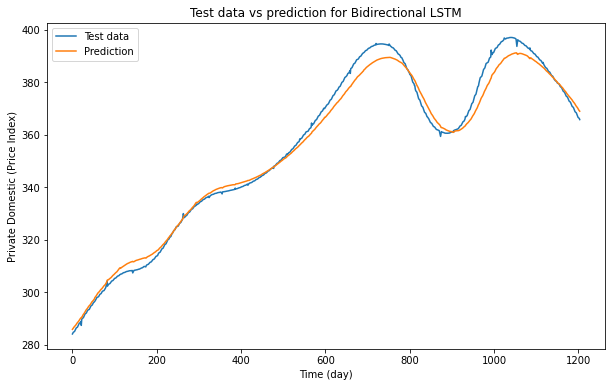

In [ ]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction


prediction_bilstm = prediction(model_bilstm)
# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(10,6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test),
             label="Test data")
    plt.plot(np.arange(range_future),
             np.array(prediction),label="Prediction")
    plt.title("Test data vs prediction for " + model_name)
    plt.legend(loc="upper left")
    plt.xlabel("Time (day)")
    plt.ylabel("Private Domestic (Price Index)")

plot_future(prediction_bilstm, "Bidirectional LSTM", y_test)



In [ ]:
#Caluclating Mean Absolute Percentage Error
mape=(sum(abs((y_test-prediction_bilstm)/y_test)))/len(y_test)*100
mape

array([0.76288648])